# Курсовой проект
### Тема: Предсказания стоимости недвижимости в г.Москва

#### Цель 
Необходимо получить (коэффициент детерминации) R2 > 0.6. 

#### Подключение библиотек

In [120]:
import numpy as np
import pandas as pd

import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()
    
    
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    df_copy = df.copy()
    start_mem = df_copy.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df_copy.columns:
        col_type = df_copy[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df_copy[col] = df_copy[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df_copy[col] = df_copy[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df_copy[col] = df_copy[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df_copy[col] = df_copy[col].astype(np.int64)  
        else:
            df_copy[col] = df_copy[col].astype('category')

    end_mem = df_copy.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df_copy

#### Пути к директориям и файлам

In [5]:
TRAIN_DATASET_PATH = 'real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = 'real-estate-price-prediction-moscow/test.csv'

### Описание датасета
* **id**            - id квартиры
* **DistrictId**    - id района
* **Rooms**         - количество комнат
* **Square**        - площадь
* **LifeSquare**    - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor**         - этаж
* **HouseFloor**    - количество этажей в доме
* **HouseYear**     - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2**  - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price**         - цена (целевая переменная)

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
# train_df = reduce_mem_usage(train_df)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [8]:
print('Строк в трейне:', train_df.shape[0])
print('Столбцов в трейне', train_df.shape[1])
print('Строк в тесте', test_df.shape[0])
print('Столбцов в тесте', test_df.shape[1])

Строк в трейне: 10000
Столбцов в трейне 20
Строк в тесте 5000
Столбцов в тесте 19


#### 1. EDA
* Исправления выбросов

* Заполнения NaN

* Идей для генерации новых фич


### Анализ целевой переменной "Price"

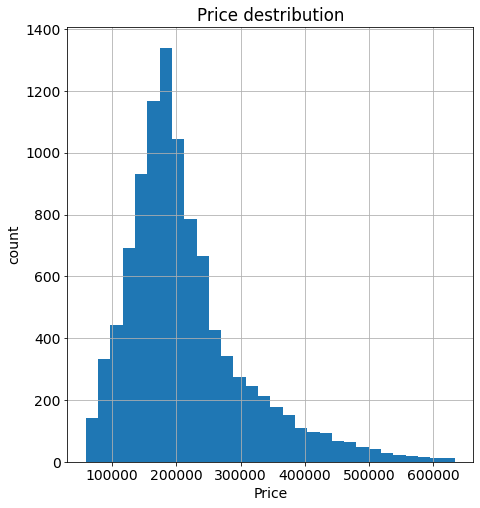

In [9]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
train_df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Price destribution')
plt.show()

In [10]:
print('Количество пропусков = ', train_df['Price'].isna().sum())

Количество пропусков =  0


#### Вывод:
Данные целевой переменной вполне приемлемы. Признак вещественный

### Анализ признаков

In [11]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [12]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

#### Вывод:

* **id**            - не интересует как признак. Нужно выкинуть
* **DistrictId**    - Нужно привести из категориалного в вещественный
* **Rooms**         - не нравится min, max значения
* **Square**        - mean и 50% отличаются
* **LifeSquare**    - mean и 50% отличаются
* **KitchenSquare** - не нравится min, max значения
* **Floor**         - mean и 50% отличаются
* **HouseFloor**    - не нравится min, max значения
* **HouseYear**     - есть цифры более чем 4 знака.
* **Ecology_1**     - Нужно обрабоать через квартилии.
* **Ecology_2**     - Нужно сделать дамми
* **Ecology_3**     - Нужно сделать дамми
* **Social_1**      - На первый взгляд все ок.
* **Social_2**      - На первый взгляд все ок.
* **Social_3**      - mean и 50% отличаются
* **Healthcare_1**  - mean и 50% отличаются
* **Helthcare_2**   - под воспросом (анализировать на графике)
* **Shops_1**       - mean и 50% отличаются
* **Shops_2**       - Нужно сделать дамми
* **Price**         - Пока под вопросом, но mean и 50% отличаются

#### Анализ пропусков

In [13]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Выведем матрицу корреляций, для того что бы увидеть всю картину целиком.

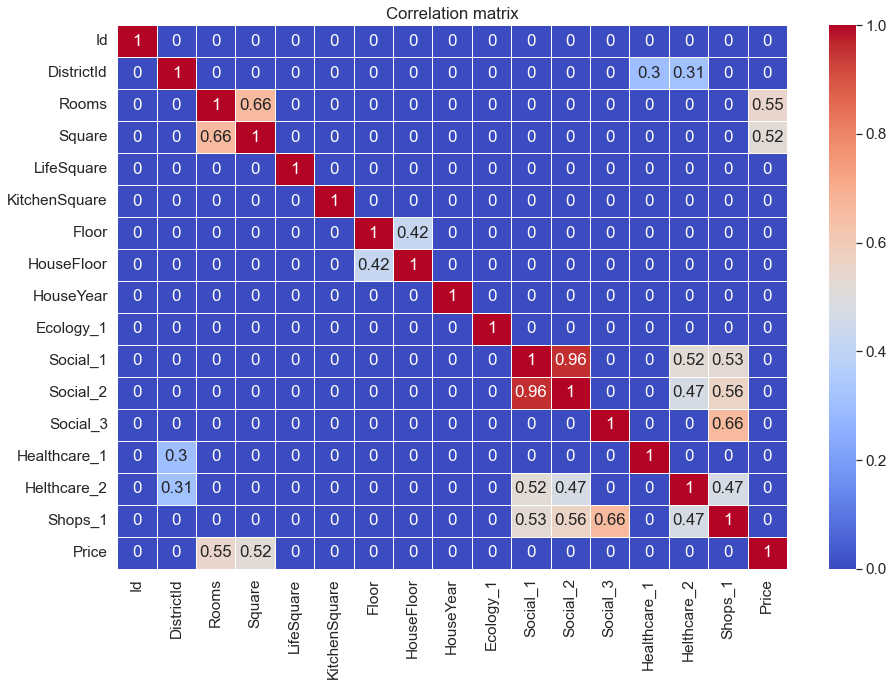

In [14]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

#### Вещественные признаки
Обработка выбросов

К вещественным признакам относятся

* Rooms                - float64
* Square               - float64
* LifeSquare           - float64
* KitchenSquare        - float64
* Floor                - int8
* HouseFloor           - float64
* HouseYear            - int32
* Ecology_1            - float64
* Social_1             - int8
* Social_2             - int16
* Social_3             - int16
* Healthcare_1         - float64
* Helthcare_2          - int8
* Shops_1              - int8

In [15]:
def hist(df, feature_name):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    train_df[feature_name].hist(bins=30)
    plt.ylabel('count')
    plt.xlabel(feature_name)

    plt.title(f'{feature_name} destribution')
    plt.show()
    
    
def create_out_feature(df, feature_name, condition, correct_value):
    df[f'{feature_name}_outlier'] = 0
    df.loc[condition, f'{feature_name}_outlier'] = 1
    df.loc[condition, feature_name] = correct_value
    return df

def get_quantile_values(df, feature_name, q_1, q_2):
    value_1 = train_df[feature_name].quantile(q=q_1)
    value_2 = train_df[feature_name].quantile(q=q_2)   
    return value_1, value_2

Обработка **Rooms**

In [16]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [17]:
# Rooms
rooms_condition = train_df['Rooms'] == 0
train_df = create_out_feature(train_df, 'Rooms', rooms_condition, 1)
rooms_condition = train_df['Rooms'] >= 6
train_df = create_out_feature(train_df, 'Rooms', rooms_condition, train_df['Rooms'].median())

In [18]:
train_df[rooms_condition].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2004,5927,57,2.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.323792,1
2728,14865,9,2.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,172329.270863,1
6088,8491,1,2.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,B,1,264,0,NaN,0,1,B,78364.616704,1
8794,14003,99,2.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,...,B,66,10573,1,1322.0,3,8,B,229661.964416,1


In [19]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

Обработка **Square** 

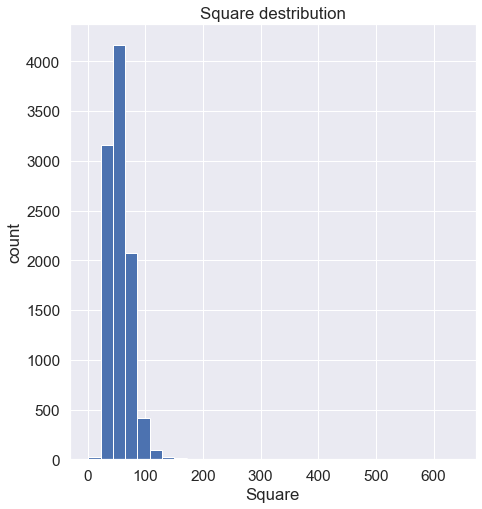

In [20]:
hist(train_df, 'Square')

Считаем выбросами все что находится в диапазоне квартилии 2.5% с обеих сторон

In [21]:
min_value, max_value = get_quantile_values(train_df, 'Square', 0.025, 0.975)
min_value, max_value

(32.10518291149681, 100.90624548226137)

In [22]:
square_condition = (train_df['Square'] < min_value) | (train_df['Square'] > max_value)
train_df = create_out_feature(train_df, 'Square', square_condition, train_df['Square'].median())

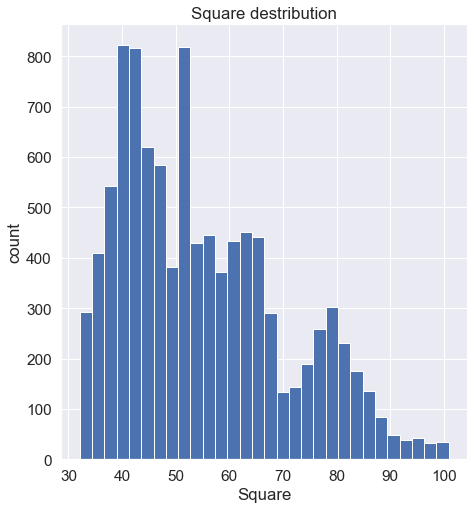

In [23]:
hist(train_df, 'Square')

Обработка **KitchenSquare**

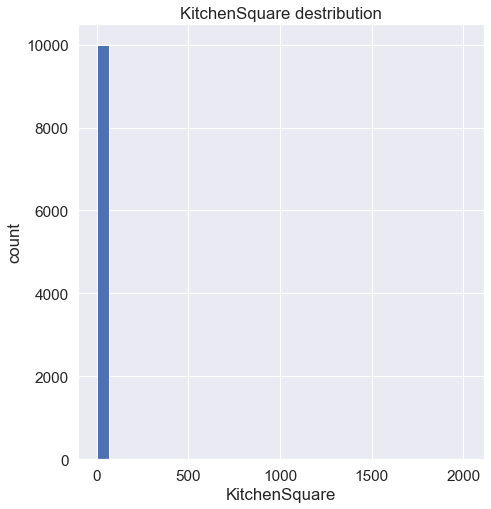

In [24]:
hist(train_df, 'KitchenSquare')

In [25]:
train_df['KitchenSquare'].value_counts().unique()

array([2460, 1306, 1169, 1075, 1038,  843,  697,  609,  249,  233,   67,
         51,   39,   31,   22,   16,   14,   12,   11,    6,    4,    3,
          2,    1], dtype=int64)

Нули обрабатывать не будет, т.к возможно это квартира-студия и у нее нет кухни. Вывод основан на том что значений 0 очень больше количество. 

In [26]:
max_value = train_df['KitchenSquare'].quantile(q=0.975)
kitchen_square_condition = (train_df['KitchenSquare'] > max_value)
train_df.loc[kitchen_square_condition].shape[0]

189

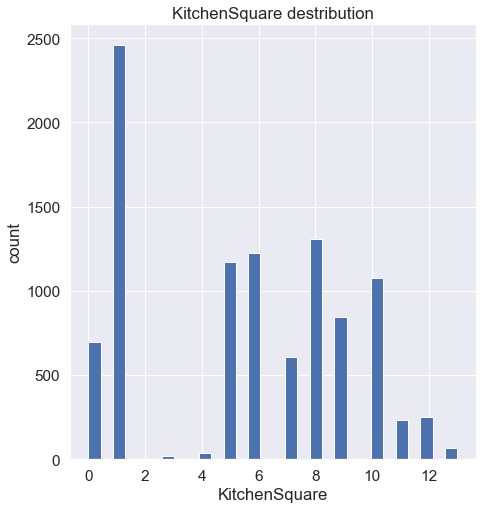

In [27]:
train_df = create_out_feature(train_df, 'KitchenSquare', kitchen_square_condition, train_df['KitchenSquare'].median())
hist(train_df, 'KitchenSquare')

Обработка **LifeSquare**

In [28]:
min_value, max_value = get_quantile_values(train_df, 'LifeSquare', 0.025, 0.975)
life_square_condition = (train_df['LifeSquare'] < min_value) | (train_df['LifeSquare'] > max_value)
train_df = create_out_feature(train_df, 'LifeSquare', life_square_condition, train_df['LifeSquare'].median())

In [29]:
# Восстановление LifeSquare
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1
train_df_condition_isna = (train_df['LifeSquare'].isna()) & (~train_df['Square'].isna()) & (~train_df['KitchenSquare'].isna())
        
train_df.loc[train_df_condition_isna, 'LifeSquare'] = train_df.loc[train_df_condition_isna, 'Square'] - train_df.loc[train_df_condition_isna, 'KitchenSquare']

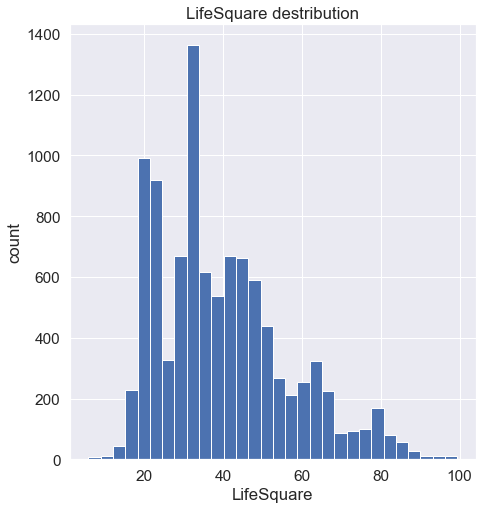

In [30]:
hist(train_df, 'LifeSquare')

Обработка **HouseFloor**

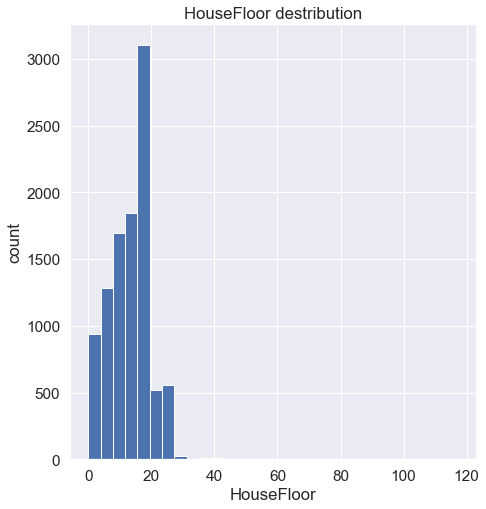

In [31]:
hist(train_df, 'HouseFloor')

In [32]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [33]:
condition = (train_df['HouseFloor'] == 0) | (train_df['HouseFloor'] > 75)
train_df.loc[condition].shape[0]

272

In [34]:
house_floor_condition = (train_df['HouseFloor'] == 0) | (train_df['HouseFloor'] > 75)
train_df = create_out_feature(train_df, 'HouseFloor', house_floor_condition, train_df['HouseFloor'].median())

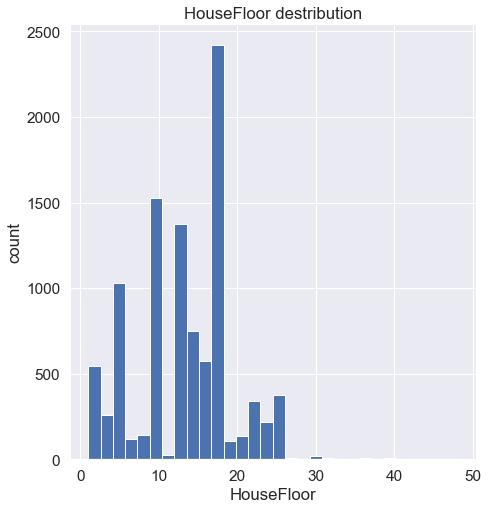

In [35]:
hist(train_df, 'HouseFloor')

In [36]:
print(f"HouseFloor min: {train_df['HouseFloor'].min()}")
print(f"HouseFloor mean: {train_df['HouseFloor'].mean()}")
print(f"HouseFloor max: {train_df['HouseFloor'].max()}")

HouseFloor min: 1.0
HouseFloor mean: 12.9315
HouseFloor max: 48.0


Обработка **Floor**

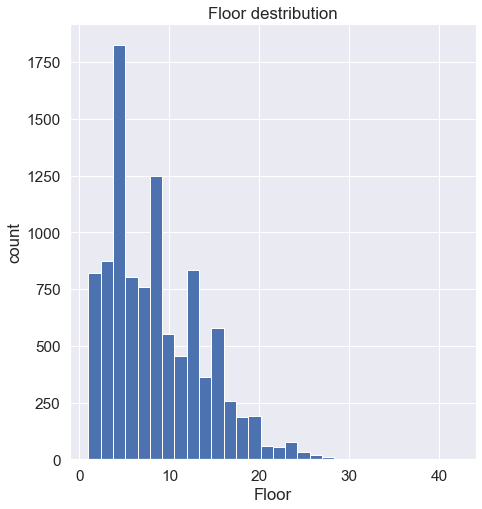

In [37]:
hist(train_df, 'Floor')

In [38]:
print(f"Floor min: {train_df['Floor'].min()}")
print(f"Floor mean: {train_df['Floor'].mean()}")
print(f"Floor max: {train_df['Floor'].max()}")

Floor min: 1
Floor mean: 8.5267
Floor max: 42


Сделаем проверку на указание не корректного этажа.

In [39]:
condition =  (train_df['Floor'] == 0)
train_df.loc[condition].shape[0]

0

In [40]:
floor_outliers = (train_df['Floor'] > train_df['HouseFloor'])
train_df[floor_outliers]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,LifeSquare_nan,HouseFloor_outlier
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,...,1,5,B,186971.926566,0,0,0,0,0,0
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,...,3,2,B,250466.980777,0,0,0,0,0,0
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,...,5,5,B,366916.246494,0,0,0,0,0,0
25,4521,6,2.0,65.409965,64.409965,1.0,18,1.0,1977,0.243205,...,0,0,B,191205.272608,0,0,0,0,1,0
26,8553,88,3.0,83.262530,32.781260,1.0,13,1.0,1977,0.127376,...,3,9,B,410883.892020,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9953,7659,57,1.0,38.485252,22.550608,8.0,19,17.0,1992,0.133215,...,3,4,A,183485.284995,0,0,0,0,0,0
9960,16258,48,3.0,96.056784,32.781260,1.0,15,1.0,2017,0.041125,...,1,10,B,524365.550705,0,0,0,1,0,0
9968,9920,1,3.0,86.487550,85.487550,1.0,18,17.0,1977,0.007122,...,0,1,B,248248.935528,0,0,0,0,1,0
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,...,0,0,B,114878.830713,0,0,0,0,0,0


In [41]:
train_df['Floor_outlier'] = 0
train_df.loc[train_df['Floor'] == 0, 'Floor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = train_df['Floor'].median()

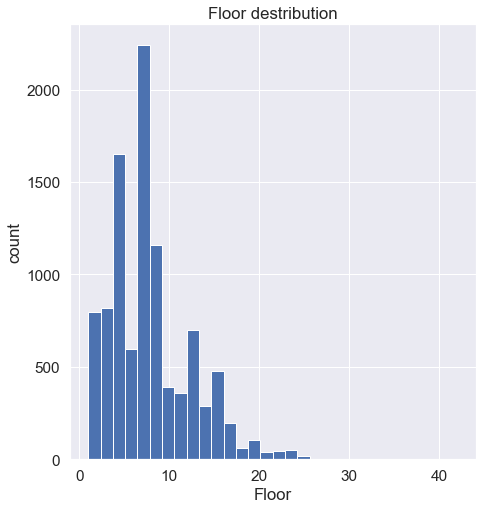

In [42]:
hist(train_df, 'Floor')

Обработка **HouseYear**

In [43]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [44]:
house_year_condition = (train_df['HouseYear'] > datetime.now().year)
train_df[house_year_condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,LifeSquare_nan,HouseFloor_outlier,Floor_outlier
8828,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,...,8,B,243028.603096,0,0,0,0,0,0,0
9163,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,...,6,B,254084.534396,0,0,0,0,0,0,0


In [45]:
train_df = create_out_feature(train_df, 'HouseYear', house_year_condition, datetime.now().year)

In [46]:
train_df[house_year_condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,LifeSquare_nan,HouseFloor_outlier,Floor_outlier,HouseYear_outlier
8828,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,2021,0.319809,...,B,243028.603096,0,0,0,0,0,0,0,1
9163,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,2021,0.136330,...,B,254084.534396,0,0,0,0,0,0,0,1


Обработка **Ecology_1**

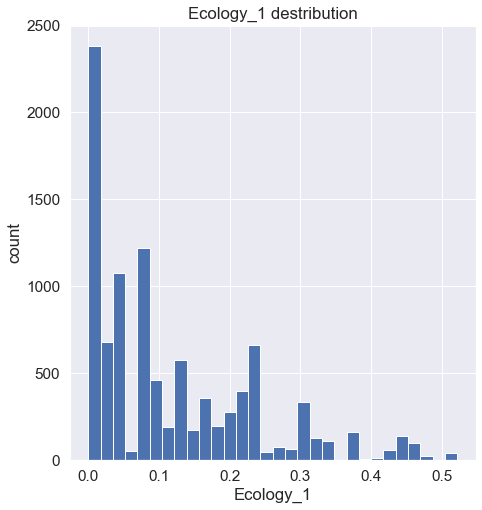

In [47]:
hist(train_df, 'Ecology_1')

In [48]:
min_value, max_value = get_quantile_values(train_df, 'Ecology_1', 0.025, 0.975)
ecology_1_condition = (train_df['Ecology_1'] < min_value) | (train_df['Ecology_1'] > max_value)
train_df = create_out_feature(train_df, 'Ecology_1', ecology_1_condition, train_df['Ecology_1'].median())

Обработка **Social_2**

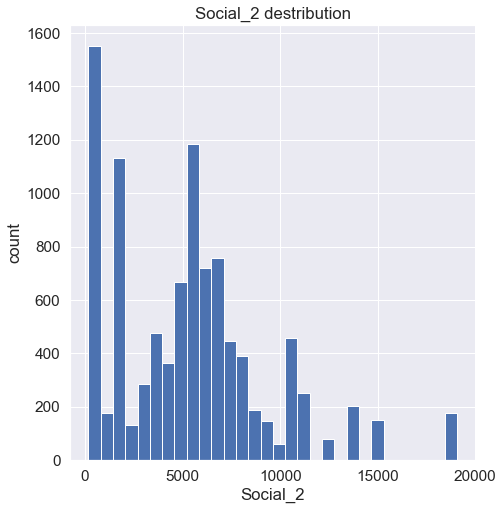

In [49]:
hist(train_df, 'Social_2')

In [50]:
min_value, max_value = get_quantile_values(train_df, 'Social_2', 0.025, 0.925)
social_2_condition = (train_df['Social_2'] < min_value) | (train_df['Social_2'] > max_value)
train_df = create_out_feature(train_df, 'Social_2', social_2_condition, train_df['Social_2'].median())

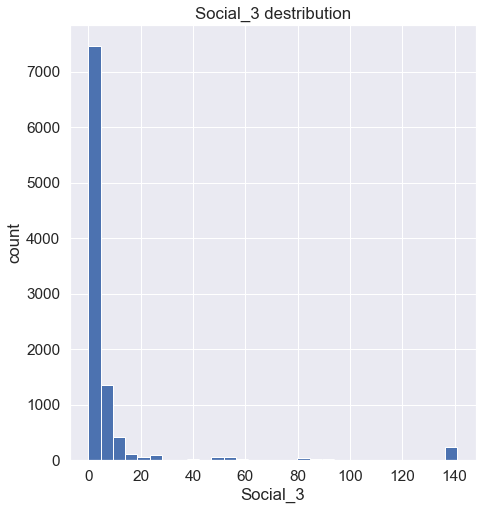

In [51]:
hist(train_df, 'Social_3')

In [52]:
min_value, max_value = get_quantile_values(train_df, 'Social_3', 0.025, 0.925)
social_3_condition = (train_df['Social_3'] < min_value) | (train_df['Social_3'] > max_value)
train_df = create_out_feature(train_df, 'Social_3', social_3_condition, train_df['Social_3'].median())

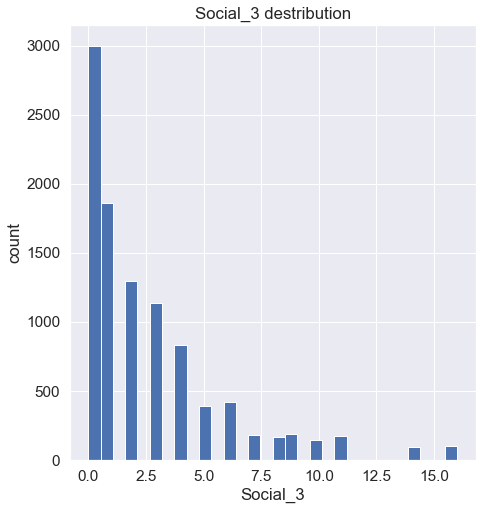

In [53]:
hist(train_df, 'Social_3')

Обработка **Shops_1**

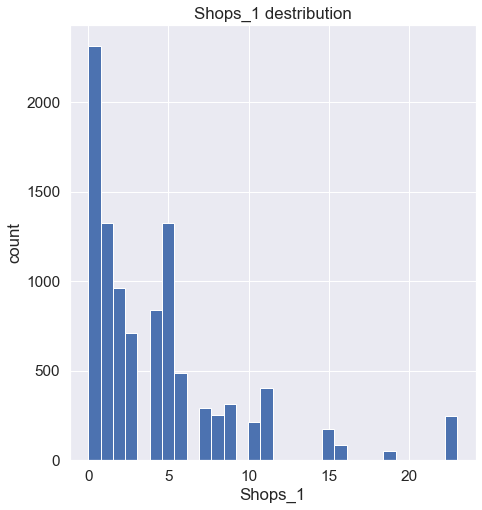

In [54]:
hist(train_df, 'Shops_1')

In [55]:
min_value, max_value = get_quantile_values(train_df, 'Shops_1', 0.025, 0.925)
shops_1_condition = (train_df['Shops_1'] < min_value) | (train_df['Shops_1'] > max_value)
train_df = create_out_feature(train_df, 'Shops_1', shops_1_condition, train_df['Shops_1'].median())

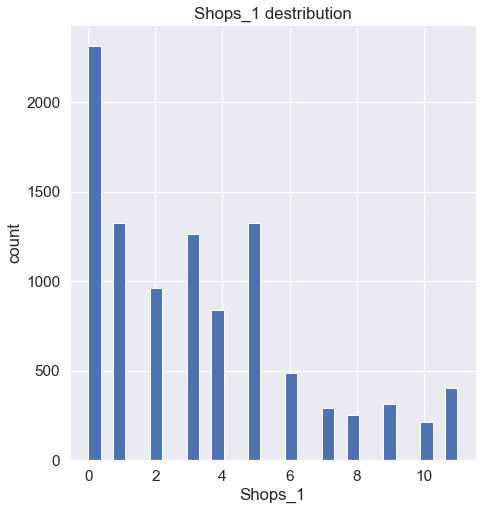

In [56]:
hist(train_df, 'Shops_1')

Обработка **Healthcare_1**

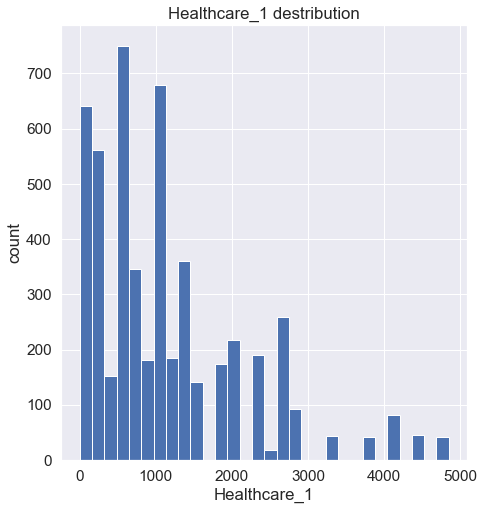

In [57]:
hist(train_df, 'Healthcare_1')

В признаке есть пропущенные значения

In [58]:
train_df['Healthcare_1'].isna().sum()

4798

In [59]:
# Восстановление Healthcar__1
train_df['Healthcare_1_nan'] = train_df['Healthcare_1'].isna() * 1
district_id_and_healthcare_1 = train_df[['DistrictId', 'Healthcare_1']]
med_district_id_and_healthcare_1 = district_id_and_healthcare_1.reset_index()\
                .groupby('DistrictId', as_index=False).agg({'Healthcare_1':'median'}) \
                .rename(columns={'Healthcare_1':'Healthcare_1_med'})

med_district_id_and_healthcare_1.loc[med_district_id_and_healthcare_1['Healthcare_1_med'].isna(), \
                                        'Healthcare_1_med'] \
                                      = med_district_id_and_healthcare_1['Healthcare_1_med'].median()

train_df = train_df.merge(med_district_id_and_healthcare_1, on=['DistrictId'], how='left')

train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1_med']
train_df = train_df.drop(columns=['Healthcare_1_med'], axis=1)
train_df['Healthcare_1'].isna().sum()

0

#### Категориальные признаки 
Создание новых признаков

К категориальным признакам относятся 
* DistrictId - int16
* Ecology_2 - category
* Ecology_3 - category
* Shops_2 - category

1) Признак **DistrictId** нужно перевести в вещественный

In [60]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [61]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')

In [62]:
train_df = train_df.drop('DistrictId', axis=1)
train_df.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,LifeSquare_nan,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Ecology_1_outlier,Social_2_outlier,Social_3_outlier,Shops_1_outlier,Healthcare_1_nan,DistrictSize
0,11809,3.0,52.513310,42.513310,10.0,4,10.0,2014,0.075424,B,...,1,0,0,0,0,0,0,0,1,851
1,3013,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,...,0,0,0,0,0,0,0,0,0,78
2,8215,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,...,0,0,0,0,0,0,0,0,0,652
3,2352,1.0,40.409907,39.409907,1.0,10,22.0,1977,0.007122,B,...,1,0,0,0,0,0,0,0,1,652
4,13866,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,...,0,0,0,0,0,0,0,0,1,89


***Dummies***

In [63]:
print(f'Ecology_2 = {train_df["Ecology_2"].unique()}')
print(f'Ecology_3 = {train_df["Ecology_3"].unique()}')
print(f'Shops_2 = {train_df["Shops_2"].unique()}')

Ecology_2 = ['B' 'A']
Ecology_3 = ['B' 'A']
Shops_2 = ['B' 'A']


In [64]:
binary_to_numbers = {0: 'A', 1: 'B'}
train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [65]:
train_df = pd.get_dummies(train_df)
train_df.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3_outlier,Shops_1_outlier,Healthcare_1_nan,DistrictSize,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,11809,3.0,52.513310,42.513310,10.0,4,10.0,2014,0.075424,11,...,0,0,1,851,0,1,0,1,0,1
1,3013,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,...,0,0,0,78,0,1,0,1,0,1
2,8215,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,...,0,0,0,652,0,1,0,1,0,1
3,2352,1.0,40.409907,39.409907,1.0,10,22.0,1977,0.007122,1,...,0,0,1,652,0,1,0,1,0,1
4,13866,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,...,0,0,1,89,0,1,0,1,0,1


#### Отбор и построение новых признаков

In [66]:
train_df.columns

Index(['Id', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price',
       'Rooms_outlier', 'Square_outlier', 'KitchenSquare_outlier',
       'LifeSquare_outlier', 'LifeSquare_nan', 'HouseFloor_outlier',
       'Floor_outlier', 'HouseYear_outlier', 'Ecology_1_outlier',
       'Social_2_outlier', 'Social_3_outlier', 'Shops_1_outlier',
       'Healthcare_1_nan', 'DistrictSize', 'Ecology_2_A', 'Ecology_2_B',
       'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')

#### Target encoding

Генерируем признак **MedPriceByDistrict**

In [67]:
med_price_by_district = train_df.groupby(['DistrictSize', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictSize,Rooms,MedPriceByDistrict
0,1,1.0,180275.184229
1,1,2.0,336584.118092
2,1,3.0,424019.181486
3,2,1.0,253077.223120
4,2,2.0,423580.477982


In [68]:
train_df = train_df.merge(med_price_by_district, on=['DistrictSize', 'Rooms'], how='left')
train_df.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Shops_1_outlier,Healthcare_1_nan,DistrictSize,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,MedPriceByDistrict
0,11809,3.0,52.513310,42.513310,10.0,4,10.0,2014,0.075424,11,...,0,1,851,0,1,0,1,0,1,213530.788443
1,3013,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,...,0,0,78,0,1,0,1,0,1,165758.998528
2,8215,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,...,0,0,652,0,1,0,1,0,1,244005.272380
3,2352,1.0,40.409907,39.409907,1.0,10,22.0,1977,0.007122,1,...,0,1,652,0,1,0,1,0,1,146735.671740
4,13866,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,...,0,1,89,0,1,0,1,0,1,192188.937297


Генерируем признак **MedPriceByYear**

In [69]:
train_df['HouseYear'].min(), train_df['HouseYear'].median(), train_df['HouseYear'].max()

(1910, 1977.0, 2021)

In [70]:
bins = [0, 1941, 1945, 1980, 2000, 2010, train_df['HouseYear'].max()]
train_df['year_cat'] = pd.cut(train_df['HouseYear'], bins=bins, labels=False)  

In [71]:
train_df['Square'].min(), train_df['Square'].median(), train_df['Square'].max()

(32.10526954276245, 52.51330992401352, 100.90426263196274)

In [72]:
bins = [0, 33, 44, 55, 66, 77, train_df['Square'].max()]
train_df['square_cat'] = pd.cut(train_df['Square'], bins=bins, labels=False) 

In [73]:
med_price_by_year = train_df.groupby(['year_cat', 'square_cat'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByYear'})

med_price_by_year.tail(10)

,year_cat,square_cat,MedPriceByYear
21,4,2,238657.602449
22,4,3,260559.662544
23,4,4,347537.208018
24,4,5,380019.233452
25,5,0,94433.038958
26,5,1,126779.167458
27,5,2,155127.602423
28,5,3,186795.078224
29,5,4,186367.581739
30,5,5,242876.434083


In [74]:
train_df = train_df.merge(med_price_by_year, on=['year_cat', 'square_cat'], how='left')
train_df.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,MedPriceByDistrict,year_cat,square_cat,MedPriceByYear
0,11809,3.0,52.513310,42.513310,10.0,4,10.0,2014,0.075424,11,...,0,1,0,1,0,1,213530.788443,5,2,155127.602423
1,3013,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,...,0,1,0,1,0,1,165758.998528,2,1,157562.157696
2,8215,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,...,0,1,0,1,0,1,244005.272380,3,5,335805.873274
3,2352,1.0,40.409907,39.409907,1.0,10,22.0,1977,0.007122,1,...,0,1,0,1,0,1,146735.671740,2,1,157562.157696
4,13866,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,...,0,1,0,1,0,1,192188.937297,2,3,206507.108185


In [75]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.quantile_values = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.quantile_values = self.__get_quantile_values(X, {'Square': {'min': 0.025, 'max': 0.975},
                                                       'KitchenSquare': {'min': 0.025, 'max': 0.975},
                                                       'LifeSquare': {'min': 0.025, 'max': 0.975},
                                                       'Ecology_1': {'min': 0.025, 'max': 0.975},
                                                       'Social_1': {'min': 0.025, 'max': 0.975},
                                                       'Social_2': {'min': 0.025, 'max': 0.975},
                                                       'Social_3': {'min': 0.025, 'max': 0.975},
                                                       'Shops_1': {'min': 0.025, 'max': 0.975}
                                                      })
    
    def transform(self, X):
        """Трансформация данных"""

        X = X.copy()
        # ****************************************************************************************
        # Rooms
        rooms_condition = X['Rooms'] == 0
        X = self.__create_out_feature(X, 'Rooms', rooms_condition, 1)
        rooms_condition = X['Rooms'] >= 6
        X = self.__create_out_feature(X, 'Rooms', rooms_condition, self.medians['Rooms'])
   
        # Square 
        min_value = self.quantile_values['Square']['min']
        max_value = self.quantile_values['Square']['max']
        square_condition = (X['Square'] < min_value) | (X['Square'] > max_value)
        X = self.__create_out_feature(X, 'Square', square_condition, self.medians['Square'])

        # KitchenSquare
        max_value =  self.quantile_values['KitchenSquare']['max']
        kitchen_square_condition = (X['KitchenSquare'] > max_value)
        X = self.__create_out_feature(X, 'KitchenSquare', kitchen_square_condition, self.medians['KitchenSquare'])
 
        # LifeSquare
        min_value = self.quantile_values['LifeSquare']['min']
        max_value = self.quantile_values['LifeSquare']['max']
        life_square_condition = (X['LifeSquare'] < min_value) | (X['LifeSquare'] > max_value)
        X = self.__create_out_feature(X, 'LifeSquare', life_square_condition, self.medians['LifeSquare'])
 
        # HouseFloor
        house_floor_condition = (X['HouseFloor'] == 0) | (X['HouseFloor'] > 75)
        X = self.__create_out_feature(X, 'HouseFloor', house_floor_condition, self.medians['HouseFloor'])

        # Floor
        X['Floor_outlier'] = 0
        X.loc[X['Floor'] == 0, 'Floor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = self.medians['Floor']

        # HouseYear
        house_year_condition = (X['HouseYear'] > datetime.now().year)
        X = self.__create_out_feature(X, 'HouseYear', house_year_condition, datetime.now().year)

       # Ecology_1
        min_value = self.quantile_values['Ecology_1']['min']
        max_value = self.quantile_values['Ecology_1']['max']
        ecology_1_condition = (X['Ecology_1'] < min_value) | (X['Ecology_1'] > max_value)
        X = self.__create_out_feature(X, 'Ecology_1', ecology_1_condition, self.medians['Ecology_1'])
       
        # Social_1
        min_value = self.quantile_values['Social_1']['min']
        max_value = self.quantile_values['Social_1']['max']
        social_1_condition = (X['Social_1'] < min_value) | (X['Social_1'] > max_value)
        X = self.__create_out_feature(X, 'Social_1', social_1_condition, self.medians['Social_1'])
        
        # Social_2
        min_value = self.quantile_values['Social_2']['min']
        max_value = self.quantile_values['Social_2']['max']
        social_2_condition = (X['Social_2'] < min_value) | (X['Social_2'] > max_value)
        X = self.__create_out_feature(X, 'Social_2', social_2_condition, self.medians['Social_2'])
        
        # Social_3
        min_value = self.quantile_values['Social_3']['min']
        max_value = self.quantile_values['Social_3']['max']
        social_3_condition = (X['Social_3'] < min_value) | (X['Social_3'] > max_value)
        X = self.__create_out_feature(X, 'Social_3', social_3_condition, self.medians['Social_3'])
     
        # Shops_1
        min_value = self.quantile_values['Shops_1']['min']
        max_value = self.quantile_values['Shops_1']['max']
        shops_1_condition = (X['Shops_1'] < min_value) | (X['Shops_1'] > max_value)
        X = self.__create_out_feature(X, 'Shops_1', shops_1_condition, self.medians['Shops_1'])
        # ****************************************************************************************
        # Восстановление LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare']
        
        # Восстановление Healthcar__1
        X['Healthcare_1_nan'] = X['Healthcare_1'].isna() * 1
        district_id_and_healthcare_1 = X[['DistrictId', 'Healthcare_1']]
        med_district_id_and_healthcare_1 = district_id_and_healthcare_1.reset_index()\
                .groupby('DistrictId', as_index=False).agg({'Healthcare_1':'median'}) \
                .rename(columns={'Healthcare_1':'Healthcare_1_med'})

        med_district_id_and_healthcare_1.loc[med_district_id_and_healthcare_1['Healthcare_1_med'].isna(), \
                                        'Healthcare_1_med'] \
                                      = med_district_id_and_healthcare_1['Healthcare_1_med'].median()

        X = X.merge(med_district_id_and_healthcare_1, on=['DistrictId'], how='left')

        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['Healthcare_1_med']
        X = X.drop(columns=['Healthcare_1_med'], axis=1)
        
        # Восстановление Social_1 и Social_2
        X['Social_1_nan'] = X['Social_1'].isna() * 1
        condition =  (X['Social_1'].isna()) & (~X['Social_2'].isna())
        X.loc[condition, 'Social_1'] = X['Social_2']
        
        X['Social_2_nan'] = X['Social_2'].isna() * 1
        condition =  (X['Social_2'].isna()) & (~X['Social_1'].isna())
        X.loc[condition, 'Social_2'] = X['Social_1']
        
        # Заполняем оставшиеся nan медианами    
        X.fillna(self.medians, inplace=True)
        
        return X
    
    def __create_out_feature(self, df, feature_name, condition, correct_value):
        df[f'{feature_name}_outlier'] = 0
        df.loc[condition, f'{feature_name}_outlier'] = 1
        df.loc[condition, feature_name] = correct_value
    
        return df
    
    def __get_quantile_values(self, df, feature_names_and_quantiles):
        quantile_values = {}
        for feature_name, quantiles in feature_names_and_quantiles.items():
            key_1, key_2 = quantiles.keys()
            value_1 = df[feature_name].quantile(q=quantiles[key_1])
            value_2 = df[feature_name].quantile(q=quantiles[key_2])
            quantile_values[feature_name] = {key_1: value_1, key_2: value_2}
            
        return quantile_values

In [76]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_square_year = None
        self.med_price_by_square_year_median = None
        self.house_year_max = None
        self.square_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        df = X.copy()
        # Генерируем признак **MedPriceByDistrict**
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        # Генерируем признак MedPriceByYear
        if y is not None:
            self.square_max = df['Square'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.square_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_square_year = df.groupby(['year_cat', 'square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquareYear'})
            self.med_price_by_square_year_median = self.med_price_by_square_year['MedPriceBySquareYear'].median()
        
    def transform(self, X):  
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers) 
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        train_df = pd.get_dummies(X)
        
        # DistrictId
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        X['DistrictSize'].fillna(5, inplace=True)
        
        # More categorical features
        X = self.square_to_cat(X) 
        X = self.year_to_cat(X)   
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_square_year_median is not None:
            X = X.merge(self.med_price_by_square_year, on=['year_cat', 'square_cat'], how='left')
            X['MedPriceBySquareYear'].fillna(self.med_price_by_square_year_median, inplace=True)
        
        return X
    
    def square_to_cat(self, X):
        bins = [0, 33, 44, 55, 66, 77, X['Square'].max()]
        X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False) 

        X['square_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X  

#### Отбор признаков

In [77]:
train_df.columns.tolist()

['Id',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Rooms_outlier',
 'Square_outlier',
 'KitchenSquare_outlier',
 'LifeSquare_outlier',
 'LifeSquare_nan',
 'HouseFloor_outlier',
 'Floor_outlier',
 'HouseYear_outlier',
 'Ecology_1_outlier',
 'Social_2_outlier',
 'Social_3_outlier',
 'Shops_1_outlier',
 'Healthcare_1_nan',
 'DistrictSize',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'MedPriceByDistrict',
 'year_cat',
 'square_cat',
 'MedPriceByYear']

In [121]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = [ 'Rooms_outlier',
                      'Square_outlier',
                      'KitchenSquare_outlier',
                      'LifeSquare_outlier',
                      'HouseFloor_outlier',
                      'Floor_outlier',
                      'HouseYear_outlier',
                      'Social_3_outlier',
                      'Shops_1_outlier',
                      'DistrictSize']

target_name = 'Price'

#### Разбиение на train и test

In [122]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [123]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [124]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

C:\Users\User\AppData\Local\Temp/ipykernel_20820/3121536519.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.medians = X.median()


In [125]:
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 35), (3300, 35), (5000, 35))

In [126]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 41), (3300, 41), (5000, 41))

In [127]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [128]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

#### Построение модели

In [129]:
parameters = {
    'n_estimators': [100, 150, 200],
    'min_samples_leaf': np.arange(5, 15),
    'max_depth': np.arange(4, 9),
}

clf = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

In [130]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': array([4, 5, 6, 7, 8]),
                         'min_samples_leaf': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'n_estimators': [100, 150, 200]},
             scoring='r2')

In [132]:
clf.best_params_

{'max_depth': 5, 'min_samples_leaf': 12, 'n_estimators': 200}

In [133]:
#rf_model = RandomForestRegressor(max_depth=8, max_features=8, n_estimators=200, random_state=21, criterion='mse')
rf_model = GradientBoostingRegressor(max_depth=5, min_samples_leaf=12, n_estimators=200, random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=12,
                          n_estimators=200, random_state=21)

Train R2:	0.871
Test R2:	0.739


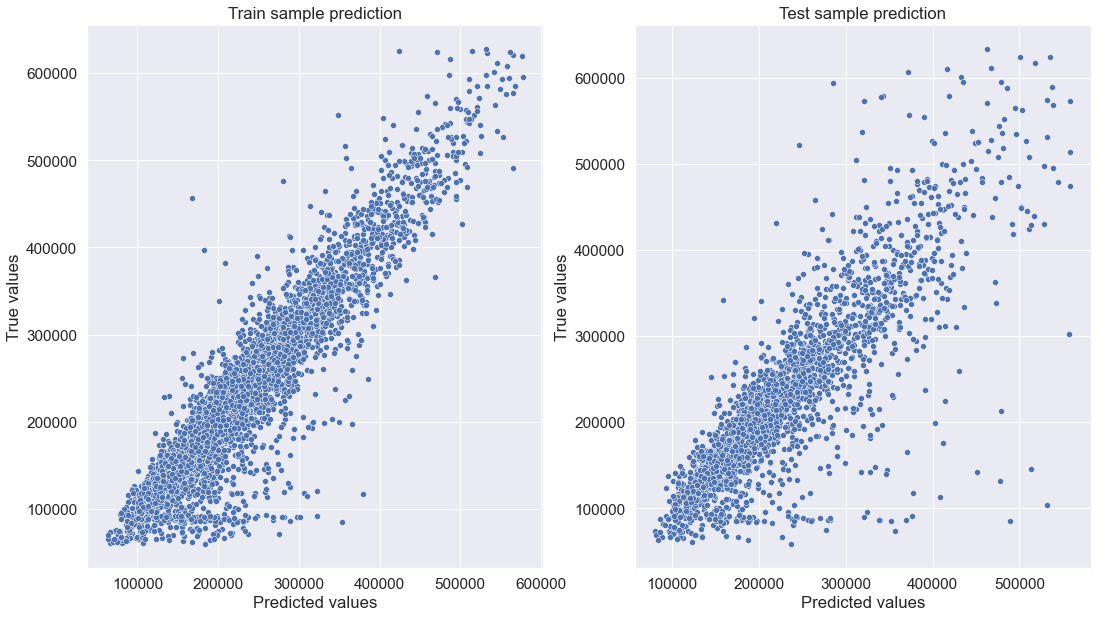

In [134]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [135]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.71472497, 0.68817539, 0.70869985])

In [136]:
cv_score.mean()

0.7038667410503834

#### Важность признаков

In [138]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
0,Rooms,0.296438
26,DistrictSize,0.177696
1,Square,0.171673
12,Social_3,0.062796
6,HouseYear,0.042200
2,LifeSquare,0.037004
18,Square_outlier,0.033260
7,Ecology_1,0.031933
13,Healthcare_1,0.029623
11,Social_2,0.024596


#### Прогнозирование на тестовом датасете

In [139]:
test_df.shape

(5000, 27)

In [140]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Social_3_outlier,Shops_1_outlier,DistrictSize
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,0,0,0,0,0,0,0,0,0,76.0
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,0,0,0,0,164.0
2,2.0,59.463678,50.463678,9.0,19,19.0,1977,0.211401,1,1,...,0,0,0,0,0,0,0,0,0,580.0
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,0,0,0,0,0,0,0,0,372.0
4,1.0,53.837056,52.837056,1.0,8,17.0,1977,0.309479,1,1,...,0,0,0,0,0,0,0,0,0,65.0


In [141]:
submit = pd.read_csv('real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [142]:
predictions = rf_model.predict(test_df)
predictions

array([164113.20426589, 124042.47027514, 140212.43145757, ...,
       148497.93821779, 188239.38923675, 245361.29359672])

In [143]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,164113.204266
1,5925,124042.470275
2,960,140212.431458
3,3848,133540.902240
4,746,207121.801191


In [144]:
submit.to_csv('rf_submit.csv', index=False)